In [1]:
using Symbolics
include("GradientDescent.jl")
include("CustomPlots.jl")

plot_lse (generic function with 2 methods)

# Automatic Differentiation through a Linear System of Equations
Imagine a linear system of equations that solves $A x = b$, where both $A(p)$ and $b(p)$ depend on some number of parameters $p$.

In [2]:
using LinearAlgebra

A(p) = [p[1] p[2]; p[3] p[4]];
b(p) = [p[3]^2; p[4]];
x(p) = A(p) \ b(p);

In [3]:
@variables p1 p2 p3 p4;
P = [p1, p2, p3, p4]

4-element Vector{Num}:
 p1
 p2
 p3
 p4

In [4]:
A(P)

2×2 Matrix{Num}:
 p1  p2
 p3  p4

In [5]:
b(P)

2-element Vector{Num}:
 p3^2
   p4

Solve $A(p) x = b(p)$

In [6]:
x(P)

2-element Vector{Num}:
 ((-p2*(p4 + (-(p3^3)) / p1)) / (p4 + (-p2*p3) / p1) + p3^2) / p1
                     (p4 + (-(p3^3)) / p1) / (p4 + (-p2*p3) / p1)

In [7]:
P₁ = [1 2 1 1]
x(P₁)

2-element Vector{Float64}:
  1.0
 -0.0

## Assuming Direct Solve
* Given the concrete values for $P$, we create $A$ and $b$ based on these value.
* Then, we solve $A x = b$

In [8]:
A₁ = A(P₁)

2×2 Matrix{Int64}:
 1  2
 1  1

In [9]:
b₁ = b(P₁)

2-element Vector{Int64}:
 1
 1

In [10]:
x₁ = x(P₁)

2-element Vector{Float64}:
  1.0
 -0.0

## Visualize the LSE

In [11]:
line1(A, b) = (x1, x2) -> x1 * A[1, 1] + x2 * A[1, 2] - b[1]
line2(A, b) = (x1, x2) -> x1 * A[2, 1] + x2 * A[2, 2] - b[2]

line2 (generic function with 1 method)

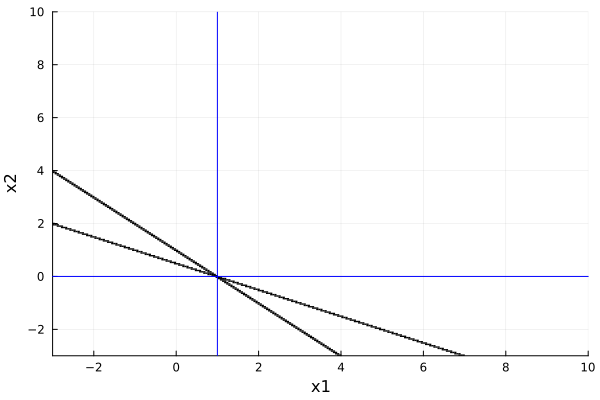

In [12]:
plot_lse(P₁)

## Using $x$ for downstream tasks
Imagine we want to tune $p$ such that the resulting $x$ is as close a possible to some defined $x^*$.

In [13]:
x_star = [5, 6];

As we can see below, the error $E(P) = ||x(P) - x^*||_2$ is parametrized by $P$, and we can take the derivative of it with respect to $P$.

In [14]:
using LinearAlgebra

error(p, x_star) = norm(x(p) - x_star)
error(p) = norm(x(p) - x_star)
error(P)

sqrt(abs2(-5 + ((-p2*(p4 + (-(p3^3)) / p1)) / (p4 + (-p2*p3) / p1) + p3^2) / p1) + abs2(-6 + (p4 + (-(p3^3)) / p1) / (p4 + (-p2*p3) / p1)))

In [15]:
using Flux

grad(p) = Flux.gradient(error, p)[1];

In [16]:
grad(P₁)

1×4 Matrix{Float64}:
 0.27735  0.0  -0.27735  -0.27735

In [17]:
using Statistics

function update(P)
    ∇P = grad(P)
    new_P = P - 0.01 .* ∇P
    return new_P, ∇P
end

nrows(xs) = size(xs, 1);

grad_norms(ps) = [norm(grad(ps[i, :])) for i in 1:nrows(ps)]

update(P₁)

([0.9972264990188738 2.0 1.002773500981126 1.002773500981126], [0.2773500981126146 0.0 -0.2773500981126146 -0.2773500981126146])

In [18]:
errors, xs, ps = GradientDescent.opt(P₁, update, error, x, n_iterations=500);

Iteration 100. x=[0.977, 0.187]
Iteration 200. x=[2.481, -0.28]
Iteration 300. x=[5.276, 0.827]
Iteration 400. x=[3.482, 6.801]
Iteration 500. x=[4.913, 5.981]


[ Info: Saved animation to /Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/animation.gif


Plots.AnimatedGif("/Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/animation.gif")
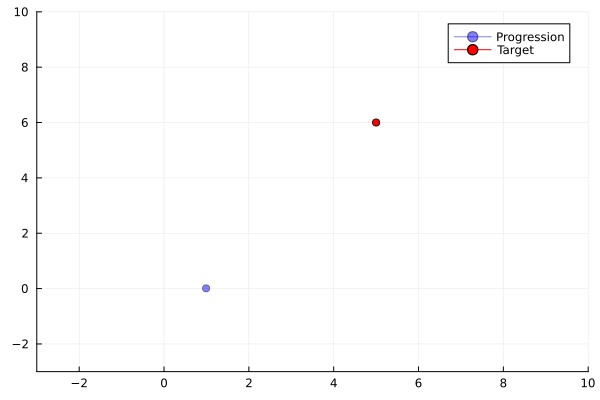

In [19]:
animate_opt(xs[1:10:end, :])

[ Info: Saved animation to /Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/lse-animation.gif


Plots.AnimatedGif("/Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/lse-animation.gif")
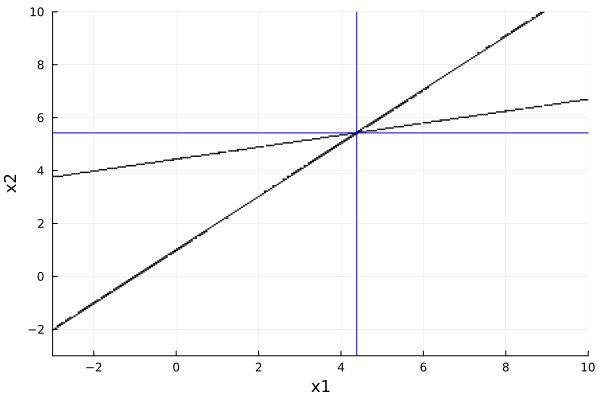

In [20]:
animate_lse(ps[end-30:end, :], 5)

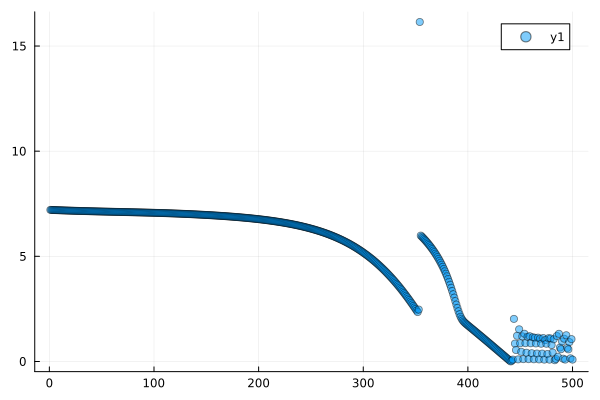

In [21]:
scatter(1:length(errors), errors, alpha=0.5)

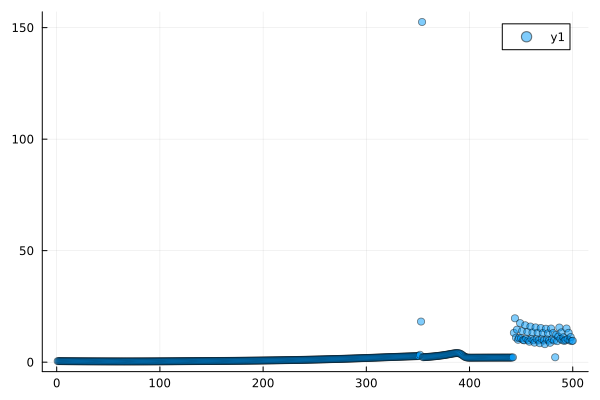

In [22]:
scatter(grad_norms(ps), alpha=0.5)

# Use Built-In Formulation for Optimization Problems

In [23]:
using Optimization
using OptimizationOptimJL

optf = OptimizationFunction(error, Optimization.AutoForwardDiff())
prob = OptimizationProblem(optf, [1.0 2 1 1], [5.0; 6.0]);

xs = []
ps = []
grads = []
function callback(state, l)
    push!(ps, state.u)
    push!(xs, x(state.u))
    push!(grads, grad(state.u))
    false
end

solution = solve(prob, BFGS(), callback=callback, reltol=0.01)

xs = hcat(xs...)';
ps = vcat(ps...);
grads = vcat(grads...);

In [24]:
show(solution);

retcode: Success
u: [0.6822944031150172 3.543284270878561 4.967008922968274 -4.967008922968273]
Final objective value:     8.881784197001252e-16


[ Info: Saved animation to /Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/animation.gif


Plots.AnimatedGif("/Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/animation.gif")
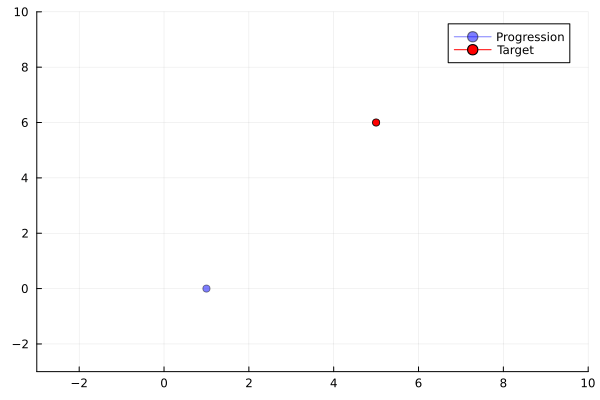

In [25]:
animate_opt(xs, 10)

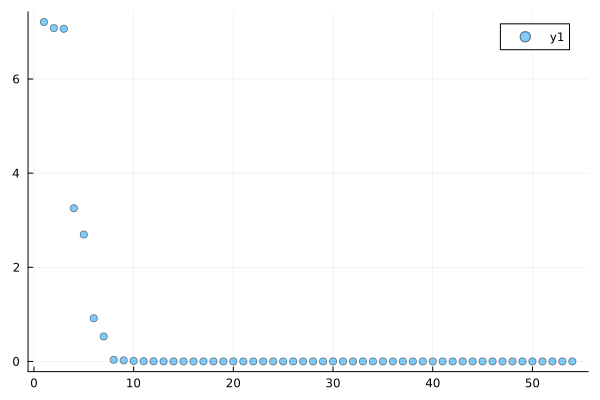

In [26]:
errors = [error(ps[i, :]) for i in 1:nrows(ps)]
scatter(1:length(errors), errors, alpha=0.5)

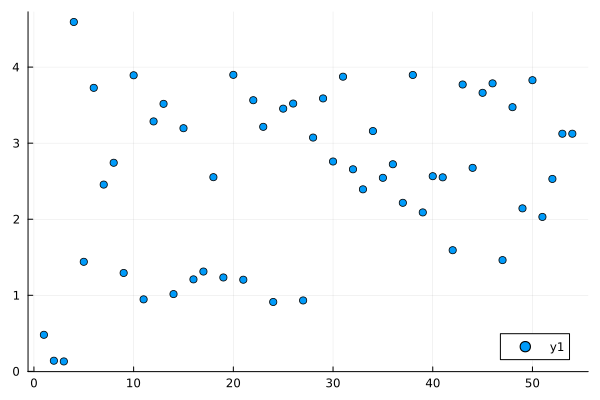

In [27]:
scatter(grad_norms(ps))

[ Info: Saved animation to /Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/lse-animation.gif


Plots.AnimatedGif("/Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/lse-animation.gif")
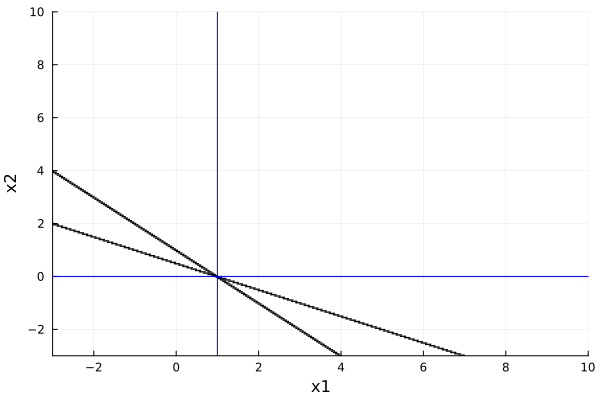

In [28]:
animate_lse(ps, 1)

# Analyse solution

In [29]:
p_final = ps[end, :]
A(p_final)

2×2 Matrix{Float64}:
 0.682294   3.54328
 4.96701   -4.96701

In [30]:
b(p_final)

2-element Vector{Float64}:
 24.671177640846455
 -4.967008922968273

In [31]:
x(p_final)

2-element Vector{Float64}:
 5.0
 6.000000000000001